Data loaded successfully from /content/Train_data.csv
Data loaded successfully from /content/Test_data.csv
Data has 25192 rows and 42 columns.
First few rows of the data:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_

<ipython-input-3-467bab6db1ed>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
<ipython-input-3-467bab6db1ed>:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

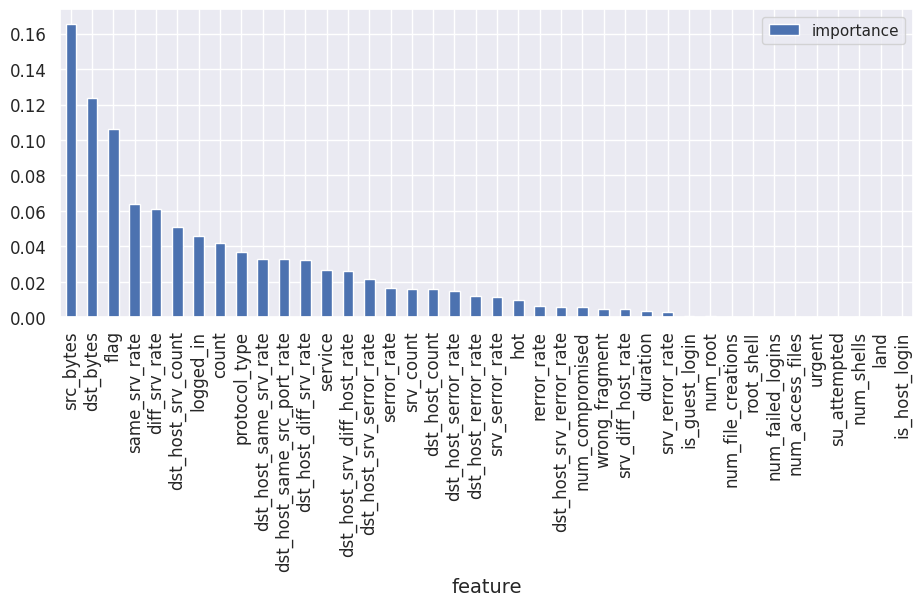

KNN Accuracy: 0.9918
Logistic Regression Accuracy: 0.9561
Naive Bayes Accuracy: 0.9137
Decision Tree Accuracy: 0.9946
SVM Accuracy: 0.9585
Created new SQLite database: processed_data.db
Data saved to database successfully.


In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sqlite3
import os

# Settings
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Function to load dataset and handle errors
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: No data found in the file at {file_path}")
        return None
    except Exception as e:
        print(f"Unexpected error while loading the file: {e}")
        return None

# Function for basic data exploration
def explore_data(df):
    if df is not None:
        print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns.")
        print("First few rows of the data:")
        print(df.head())
        print("\nData types and missing values:")
        print(df.info())

# Function to clean the data (handle missing values and redundant columns)
def clean_data(df):
    try:
        # Dropping redundant columns
        df.drop(['num_outbound_cmds'], axis=1, inplace=True)

        # Handle missing values - fill with mean or mode based on column type
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col].fillna(df[col].mean(), inplace=True)

        print("Data cleaning completed.")
        return df
    except Exception as e:
        print(f"Error during data cleaning: {e}")
        return df

# Function to perform feature scaling
def scale_features(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

# Function to encode categorical columns
def encode_categorical(df):
    encoder = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = encoder.fit_transform(df[col])
    return df

# Function to visualize data distributions (histograms)
def plot_histograms(df, numerical_columns):
    df[numerical_columns].hist(figsize=(20, 15), bins=25, edgecolor='black')
    plt.tight_layout()
    plt.show()

# Function to perform feature selection
def feature_selection(df_x, df_y):
    rfc = RandomForestClassifier()
    rfc.fit(df_x, df_y)
    importances = pd.DataFrame({'feature': df_x.columns, 'importance': rfc.feature_importances_})
    importances = importances.sort_values('importance', ascending=False).set_index('feature')
    importances.plot.bar(figsize=(11, 4))
    plt.show()

    # Using RFE (Recursive Feature Elimination)
    from sklearn.feature_selection import RFE
    rfe = RFE(rfc, n_features_to_select=15)
    rfe = rfe.fit(df_x, df_y)
    selected_features = df_x.columns[rfe.support_]
    return selected_features

# Function to split data into training and test sets
def split_data(df_x, df_y):
    X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, train_size=0.70, random_state=42)
    return X_train, X_test, Y_train, Y_test

# Function to train multiple classifiers and evaluate performance
def train_classifiers(X_train, Y_train, X_test, Y_test):
    models = {
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'Logistic Regression': LogisticRegression(n_jobs=-1, random_state=0),
        'Naive Bayes': BernoulliNB(),
        'Decision Tree': DecisionTreeClassifier(),  # Use the correct DecisionTreeClassifier here
        'SVM': SVC(kernel='linear', random_state=0)
    }

    for name, model in models.items():
        model.fit(X_train, Y_train)
        score = model.score(X_test, Y_test)
        print(f"{name} Accuracy: {score:.4f}")

# Function to save processed data to SQLite database
def save_to_db(df, db_name='processed_data.db'):
    try:
        if not os.path.exists(db_name):
            conn = sqlite3.connect(db_name)
            print(f"Created new SQLite database: {db_name}")
        else:
            conn = sqlite3.connect(db_name)
            print(f"Connected to existing SQLite database: {db_name}")

        # Save dataframe to database
        df.to_sql('cleaned_data', conn, if_exists='replace', index=False)
        print("Data saved to database successfully.")
    except Exception as e:
        print(f"Error while saving data to the database: {e}")
    finally:
        conn.close()

# Main function to execute the entire pipeline
def main():
    # Load data
    train_data = load_data("/content/Train_data.csv")
    test_data = load_data("/content/Test_data.csv")

    # Explore the data
    explore_data(train_data)

    # Clean the data
    train_data = clean_data(train_data)
    test_data = clean_data(test_data)

    # Scale features
    train_data = scale_features(train_data)
    test_data = scale_features(test_data)

    # Encode categorical columns
    train_data = encode_categorical(train_data)
    test_data = encode_categorical(test_data)

    # Feature selection
    df_x = train_data.drop(['class'], axis=1)
    df_y = train_data['class']
    selected_features = feature_selection(df_x, df_y)

    # Split data into train and test sets
    X_train, X_test, Y_train, Y_test = split_data(df_x, df_y)

    # Train classifiers and evaluate
    train_classifiers(X_train, Y_train, X_test, Y_test)

    # Save processed data to SQLite database
    save_to_db(train_data)

# Execute the main function
if __name__ == "__main__":
    main()
